In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sparentdir = os.path.dirname(parentdir)
sys.path.insert(0,parentdir)
sys.path.insert(0,sparentdir)

import datetime
import numpy as np
import scipy.stats as stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import create
import generate
import recall
import simulations
import simsave
import load_curves

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib as mpl
import copy
import pickle
import numpy as np
import pandas as pd
import time
import seaborn as sns


N = 100
p = 0.5

frac = 0.1
frac2s = [0.5, 1.0]
c = 0.65
r = 0.3
M = 30
set_of_Ss = np.linspace(-5,10.0,151)
set_of_Cs = np.linspace(0.2,0.7,11)
s_space = np.linspace(-10.0,15.0,10001)

In [4]:
recovered_s_control = np.load('./saves_final/recovered_s_control.npy')
recovered_s_hlesion = np.load('./saves_final/recovered_s_hlesion.npy')
recovered_s_control_lur = np.load('./saves_final/recovered_s_control_lur.npy')
recovered_s_hlesion_lur = np.load('./saves_final/recovered_s_hlesion_lur.npy')

error_known = np.load('./saves_final/error_known.npy')
error_dual = np.load('./saves_final/error_dual.npy')
error_mono = np.load('./saves_final/error_mono.npy')

proj_x_true = np.load('./saves_final/proj_x_true.npy')
proj_x_known = np.load('./saves_final/proj_x_known.npy')
proj_x_dual = np.load('./saves_final/proj_x_dual.npy')
proj_x_mono = np.load('./saves_final/proj_x_mono.npy')

In [21]:
def get_int_err(errors, dist, set_of_Ss):
    weights = dist.pdf(set_of_Ss)
    sum_prod = np.inner(errors.T,weights).sum()
    return sum_prod / np.inner(np.ones(errors.T.shape),weights).sum() 

In [64]:
def get_x_samples(dist, proj_x_true, proj_x_other, set_of_Ss, n=50):
    samples = background_dist.rvs(n)
    
    x_true = np.zeros(n)
    x_other = np.zeros(n)
    
    for i in range(n):
        i_s = np.argmin(np.abs(samples[i]-set_of_Ss))
        idx = np.random.randint(0,len(proj_x_true[0]))      
        x_true[i]  = proj_x_true[i_s,idx]
        x_other[i] = proj_x_other[i_s,idx]
                        
    return x_true, x_other

In [101]:
def get_RMSE(ss, rec_s):
    return np.sqrt(np.mean((rec_s.T-ss)**2, axis= 0))

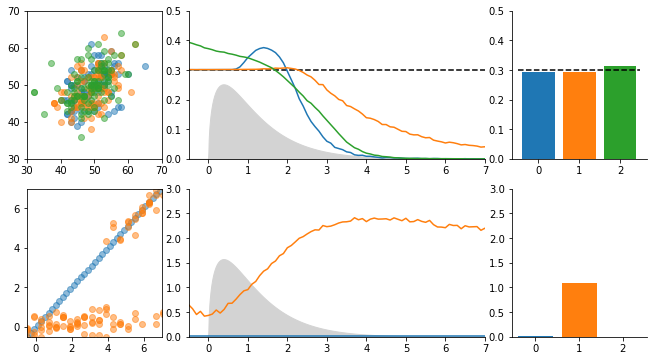

In [135]:
fig = plt.figure(figsize=(14,6))
plt.tight_layout()

gs = gridspec.GridSpec(2,5)

ax_rec = [plt.subplot(gs[0,0:1]), plt.subplot(gs[0,1:3]), plt.subplot(gs[0,3:4])]
ax_fam = [plt.subplot(gs[1,0:1]), plt.subplot(gs[1,1:3]), plt.subplot(gs[1,3:4])]

i_c_k = 4
i_c_d = 4
i_c_m = 4

x_true, x_other = get_x_samples(background_dist, proj_x_true[i_frac, i_c_k,:,:], proj_x_known[i_frac, i_c_k,:,:], set_of_Ss, n=100)
ax_rec[0].scatter(x_true, x_other, alpha=0.5)
x_true, x_other = get_x_samples(background_dist, proj_x_true[i_frac, i_c_d,:,:], proj_x_dual[i_frac, i_c_d,:,:], set_of_Ss, n=100)
ax_rec[0].scatter(x_true, x_other, alpha=0.5)
x_true, x_other = get_x_samples(background_dist, proj_x_true[i_frac, i_c_m,:,:], proj_x_mono[i_frac, i_c_m,:,:], set_of_Ss, n=100)
ax_rec[0].scatter(x_true, x_other, alpha=0.5)

ax_rec[0].set_xlim(xmin=30,xmax=70)
ax_rec[0].set_ylim(ymin=30, ymax=70)


ax_rec[1].plot(set_of_Ss, 0.3*np.ones(len(set_of_Ss)), 'k--')
ax_rec[1].plot(set_of_Ss, np.mean(error_known[i_frac, i_c_k,:,:]/100,axis=1))
ax_rec[1].plot(set_of_Ss, np.mean(error_dual[i_frac, i_c_d,:,:]/100,axis=1))
ax_rec[1].plot(set_of_Ss, np.mean(error_mono[i_frac, i_c_m,:,:]/100,axis=1))
ax_rec[1].fill_between(np.linspace(-1,7,1000),np.zeros(1000), .4*background_dist.pdf(np.linspace(-1,7,1000)),
                           color= 'lightgray', zorder=0)

ax_rec[1].set_xlim(xmin=-0.5,xmax=7)
ax_rec[1].set_ylim(ymin=0, ymax=0.5)
ax_rec[1].spines["top"].set_visible(False)
ax_rec[1].spines["right"].set_visible(False)

ax_rec[2].plot([-0.5,2.5],[0.3,0.3],'k--')
ax_rec[2].bar(0, get_int_err(error_known[i_frac,i_c_k,:,:]/100, background_dist, set_of_Ss))
ax_rec[2].bar(1, get_int_err(error_dual[i_frac,i_c_d,:,:]/100, background_dist, set_of_Ss))
ax_rec[2].bar(2, get_int_err(error_mono[i_frac,i_c_m,:,:]/100, background_dist, set_of_Ss))

ax_rec[2].set_ylim(ymin=0, ymax=0.5)
ax_rec[2].spines["top"].set_visible(False)
ax_rec[2].spines["right"].set_visible(False)

n=5
ax_fam[0].scatter(set_of_Ss[1::2], set_of_Ss[1::2], alpha = 0.5)
ax_fam[0].scatter(np.repeat(set_of_Ss[1::4],n), recovered_s_control[i_frac,i_c_d,1::4,:n].flatten(), alpha=0.5)
ax_fam[0].set_xlim(xmin=-0.5,xmax=7)
ax_fam[0].set_ylim(ymin=-0.5,ymax=7)

ax_fam[1].plot(set_of_Ss, 0.01*np.ones(len(set_of_Ss)))
ax_fam[1].plot(set_of_Ss, get_RMSE(set_of_Ss, recovered_s_control[i_frac,i_c_d,:,:]))

dist_B = stats.gamma(1.5, 0, 1/1.3)

ax_fam[1].fill_between(np.linspace(-1,7,1000),np.zeros(1000), 2.5*dist_B.pdf(np.linspace(-1,7,1000)),
                           color= 'lightgray', zorder=0)

ax_fam[1].set_xlim(xmin=-0.5,xmax=7)
ax_fam[1].set_ylim(ymin=0, ymax=3)
ax_fam[1].spines["top"].set_visible(False)
ax_fam[1].spines["right"].set_visible(False)

ax_fam[2].bar(0, 0.01)
ax_fam[2].bar(1, get_int_err(get_RMSE(set_of_Ss, recovered_s_control[i_frac,i_c_d,:,:]), background_dist, set_of_Ss))
ax_fam[2].bar(2, 0)

ax_fam[2].set_ylim(ymin=0, ymax=3)
ax_fam[2].set_ylim(ymin=0, ymax=3)
ax_fam[2].spines["top"].set_visible(False)
ax_fam[2].spines["right"].set_visible(False)

In [140]:
dist_B = stats.gamma(1.5, 0, 1/1.1)
dist_B.mean()

1.3636363636363635

In [138]:
dist_B.std()

0.9421114395319915